In [1]:
import pickle
import yaml
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
with open('config.yaml','r') as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [9]:
m = 'fnn'
d = 'pv'

results_path = 'results/'

pkl_history = results_path+d+'_'+m+'_history.pkl'
#pkl_loss = results_path+'agg_eval_loss_per_client.pkl'
#pkl_metrics = results_path+'agg_eval_metrics_per_client.pkl'

In [10]:
with open(pkl_history, 'rb') as file:
    history = pickle.load(file)
    
# with open(pkl_loss, 'rb') as file:
#     agg_eval_loss_per_client = pickle.load(file)
    
# with open(pkl_metrics, 'rb') as file:
#     agg_eval_metrics_per_client = pickle.load(file)

In [37]:
fl_results = pd.read_csv(results_path+'fl_results.csv', index_col='Unnamed: 0')
local_results = pd.read_csv(results_path+'local_results.csv', index_col='Unnamed: 0')

results = (local_results - fl_results) / local_results * 100 

In [38]:
results

,C1,C2,C3,C4
pv_tcn,15.987710,4.704674,11.329034,26.940731
pv_fnn,-6.375309,-15.918358,-2.060307,-15.028019


<AxesSubplot:>

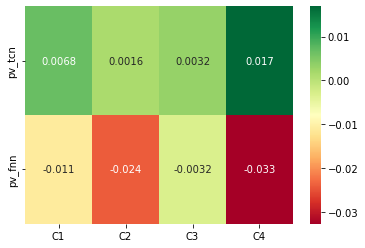

In [26]:
#sns.heatmap(results, cmap='RdYlGn', annot=True)

In [6]:
metrics = []
metrics.append(history.losses_distributed)
metrics.append(history.losses_centralized[1:])

metrics.append(history.metrics_distributed['accuracy'])
metrics.append(history.metrics_centralized['accuracy'][1:])

metrics_distributed_fit = history.metrics_distributed_fit

In [7]:
def calculate_ylim(*data_lists, buffer=0.05):
    all_y_values = [y for data in data_lists for y in data]
    y_min, y_max = min(all_y_values), max(all_y_values)
    y_range = y_max - y_min
    return y_min - buffer * y_range, y_max + buffer * y_range

def show_subplot(data):
    x1, y1 = zip(*data[0]) # loss dist
    x2, y2 = zip(*data[1]) # loss cent
    x3, y3 = zip(*data[2]) # metrics dist
    x4, y4 = zip(*data[3]) # metrics cent
    
    n_rounds = len(x1)
    ylim_top = calculate_ylim(y1, y2)
    ylim_bottom = calculate_ylim(y3, y4)

    # Erstellen der Subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
        # Subplot 1
    axs[0, 0].plot(x1, y1, marker='o')
    axs[0, 0].set_title('Loss distributed')
    axs[0, 0].set_xlabel('Rounds')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].grid(True)
    axs[0, 0].set_xticks(range(1, n_rounds+1))
    axs[0, 0].set_ylim(*ylim_top)

    # Subplot 2
    axs[0, 1].plot(x2, y2, marker='o')
    axs[0, 1].set_title('Loss centralized')
    axs[0, 1].set_xlabel('Rounds')
    axs[0, 1].set_ylabel('MSE')
    axs[0, 1].grid(True)
    axs[0, 1].set_xticks(range(0, n_rounds+1))
    axs[0, 1].set_ylim(*ylim_top)

    # Subplot 3
    axs[1, 0].plot(x3, y3, marker='o')
    axs[1, 0].set_title('Metrics distrbuted')
    axs[1, 0].set_xlabel('Rounds')
    axs[1, 0].set_ylabel('MAE')
    axs[1, 0].grid(True)
    axs[1, 0].set_xticks(range(1, n_rounds+1))
    axs[1, 0].set_ylim(*ylim_bottom)

    # Subplot 4
    axs[1, 1].plot(x4, y4, marker='o')
    axs[1, 1].set_title('Metrics centralized')
    axs[1, 1].set_xlabel('Rounds')
    axs[1, 1].set_ylabel('MAE')
    axs[1, 1].grid(True)
    axs[1, 1].set_xticks(range(0, n_rounds+1))
    axs[1, 1].set_ylim(*ylim_bottom)

    # Layout anpassen und anzeigen
    plt.tight_layout()
    plt.show()

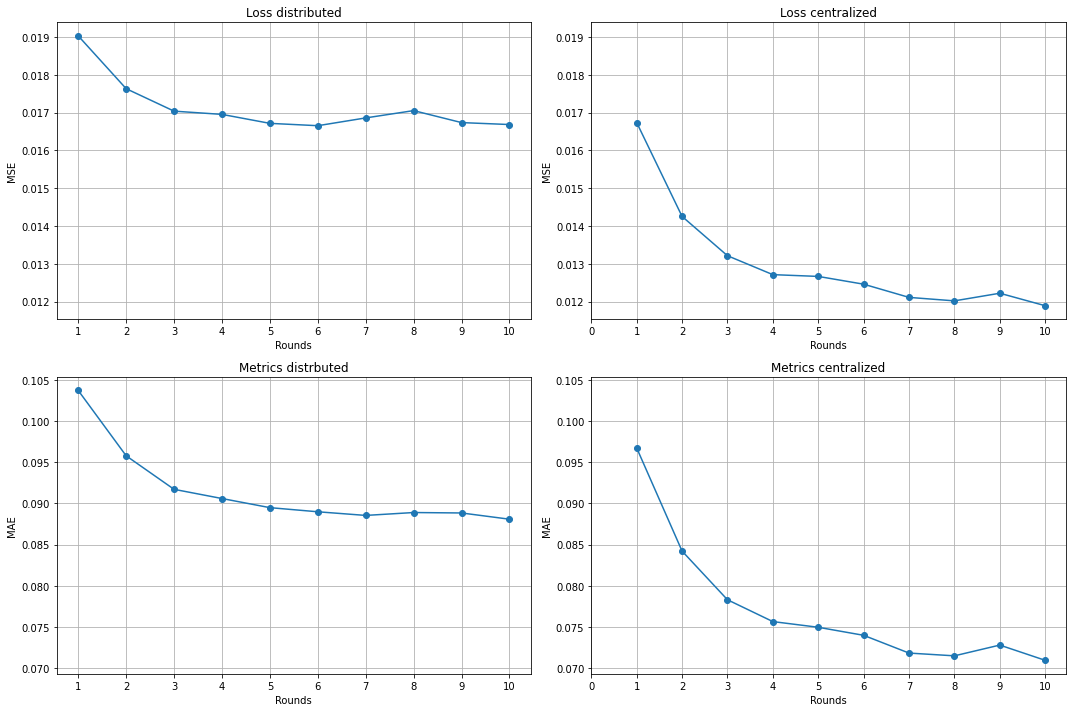

In [8]:
show_subplot(metrics)

### Loss and MAE per client and round 

In [10]:
loss = metrics_distributed_fit['loss_per_client_and_epoch']
val_loss = metrics_distributed_fit['val_loss_per_client_and_epoch']
mae = metrics_distributed_fit['mae_per_client_and_epoch']
val_mae = metrics_distributed_fit['val_mae_per_client_and_epoch']

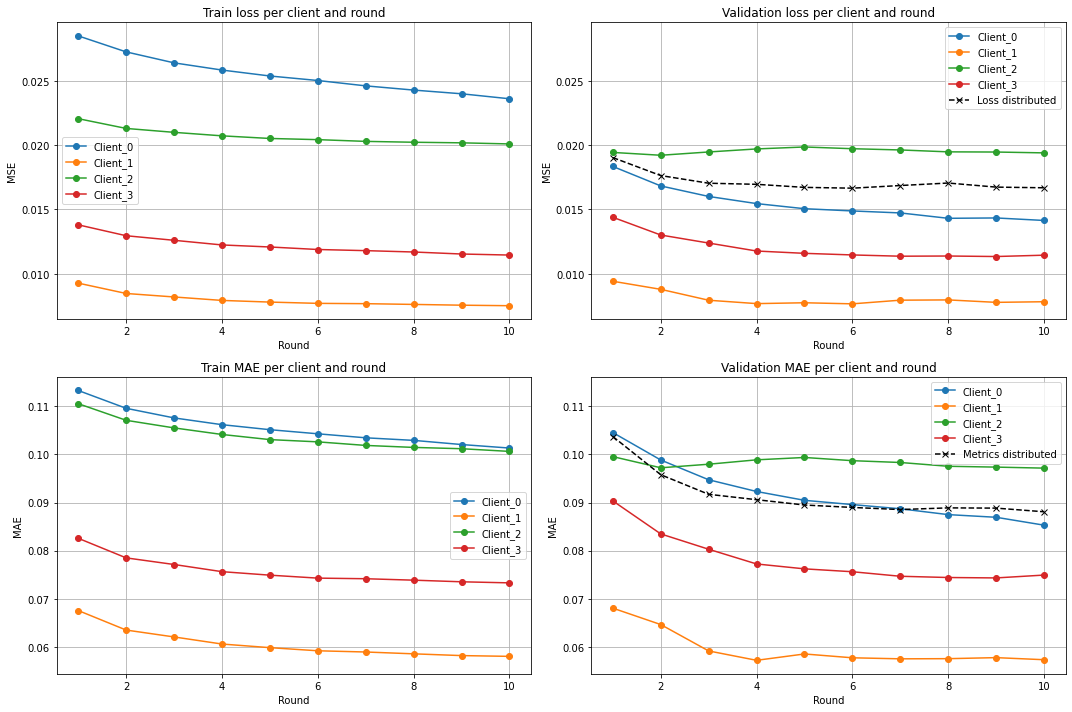

In [12]:
# Funktion zur Extraktion der letzten Werte
def extract_last_values(data_list):
    clients = list(data_list[0][1].keys())
    last_values = {client: [] for client in clients}
    epochs = [epoch for epoch, _ in data_list]
    for _, client_data in data_list:
        for client in clients:
            last_values[client].append(client_data[client][-1])
    return epochs, last_values

epochs_loss, last_values_loss = extract_last_values(loss)
epochs_val_loss, last_values_val_loss = extract_last_values(val_loss)
epochs_mae, last_values_mae = extract_last_values(mae)
epochs_val_mae, last_values_val_mae = extract_last_values(val_mae)

# Extrahieren der Werte für loss distributed und metrics distributed
x_loss_distributed, y_loss_distributed = zip(*history.losses_distributed)
x_metrics_distributed, y_metrics_distributed = zip(*history.metrics_distributed['accuracy'])

# Initialisieren der Subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Funktion zum Plotten der Daten in den Subplots
def plot_data_combined(ax, epochs, last_values, title, y_label, extra_x, extra_y, extra_label):
    for client in sorted(last_values.keys()):
        values = last_values[client]
        ax.plot(epochs, values, marker='o', label=f'{client}')
    ax.plot(extra_x, extra_y, marker='x', linestyle='--', color='black', label=extra_label)
    ax.set_title(title)
    ax.set_xlabel('Round')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)

# Plotten der Daten in den Subplots
plot_data_combined(axs[0, 0], epochs_loss, last_values_loss, 'Train loss per client and round', 'MSE', [], [], '')
plot_data_combined(axs[0, 1], epochs_val_loss, last_values_val_loss, 'Validation loss per client and round', 'MSE', x_loss_distributed, y_loss_distributed, 'Loss distributed')
plot_data_combined(axs[1, 0], epochs_mae, last_values_mae, 'Train MAE per client and round', 'MAE', [], [], '')
plot_data_combined(axs[1, 1], epochs_val_mae, last_values_val_mae, 'Validation MAE per client and round', 'MAE', x_metrics_distributed, y_metrics_distributed, 'Metrics distributed')

# Y-Limits berechnen und setzen
ylim_top = calculate_ylim(
    *[last_values_loss[client] for client in last_values_loss],
    *[last_values_val_loss[client] for client in last_values_val_loss],
    y_loss_distributed
)
for ax in axs[0, :]:
    ax.set_ylim(ylim_top)

ylim_bottom = calculate_ylim(
    *[last_values_mae[client] for client in last_values_mae],
    *[last_values_val_mae[client] for client in last_values_val_mae],
    y_metrics_distributed
)
for ax in axs[1, :]:
    ax.set_ylim(ylim_bottom)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()


### Loss and MAE per client and epoch

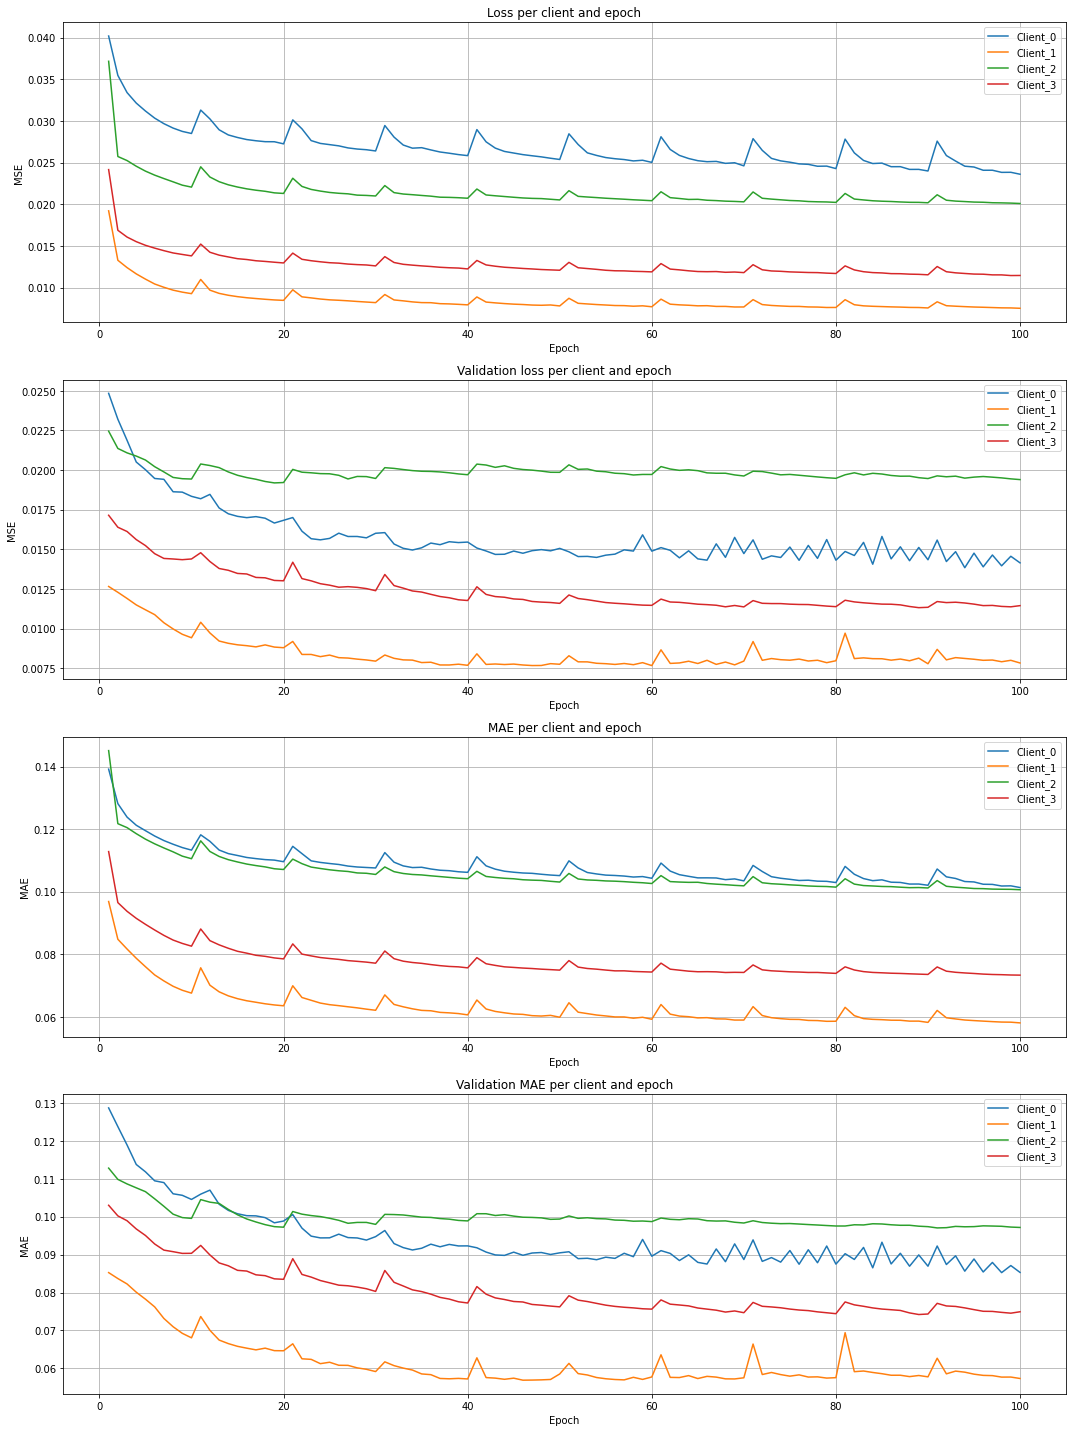

In [13]:
# Funktion zur Extraktion aller Werte für die Epochen hintereinander
def extract_all_values(data_list):
    clients = list(data_list[0][1].keys())
    all_values = {client: [] for client in clients}
    for _, client_data in data_list:
        for client in clients:
            all_values[client].extend(client_data[client])
    return all_values

# Extrahieren der Werte für jeden Plot
all_values_loss = extract_all_values(loss)
all_values_val_loss = extract_all_values(val_loss)
all_values_mae = extract_all_values(mae)
all_values_val_mae = extract_all_values(val_mae)

# Initialisieren der Subplots
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

# Funktion zum Plotten der Daten in den Subplots
def plot_data_epochs(ax, all_values, title, y_label):
    epochs = range(1, 101)
    for client in sorted(all_values.keys()):
        values = all_values[client]
        ax.plot(epochs, values, label=f'{client}')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)

# Plotten der Daten in den Subplots
plot_data_epochs(axs[0], all_values_loss, 'Loss per client and epoch', 'MSE')
plot_data_epochs(axs[1], all_values_val_loss, 'Validation loss per client and epoch', 'MSE')
plot_data_epochs(axs[2], all_values_mae, 'MAE per client and epoch', 'MAE')
plot_data_epochs(axs[3], all_values_val_mae, 'Validation MAE per client and epoch', 'MAE')

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()
